# 1. Defining the model and training

In [1]:
from utils.evaluation import Evaluation
from sklearn.preprocessing import minmax_scale, StandardScaler
from models.MLP import Linear, ReLU, Sigmoid, MLP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First we import and preprocess the data. 

Given data format description:
Each row in the training and testing datasets represents a handwritten digit image.
Columns 0 to 63 represent the input features, which are composed of 8x8 pixel images' grayscale values, reflecting the image's grayscale levels.
Column 64 (the 65th column) is the output class (label), ranging from 0 to 9, corresponding to different handwritten digits.

We need to read from the two given csv files and load them into variables.

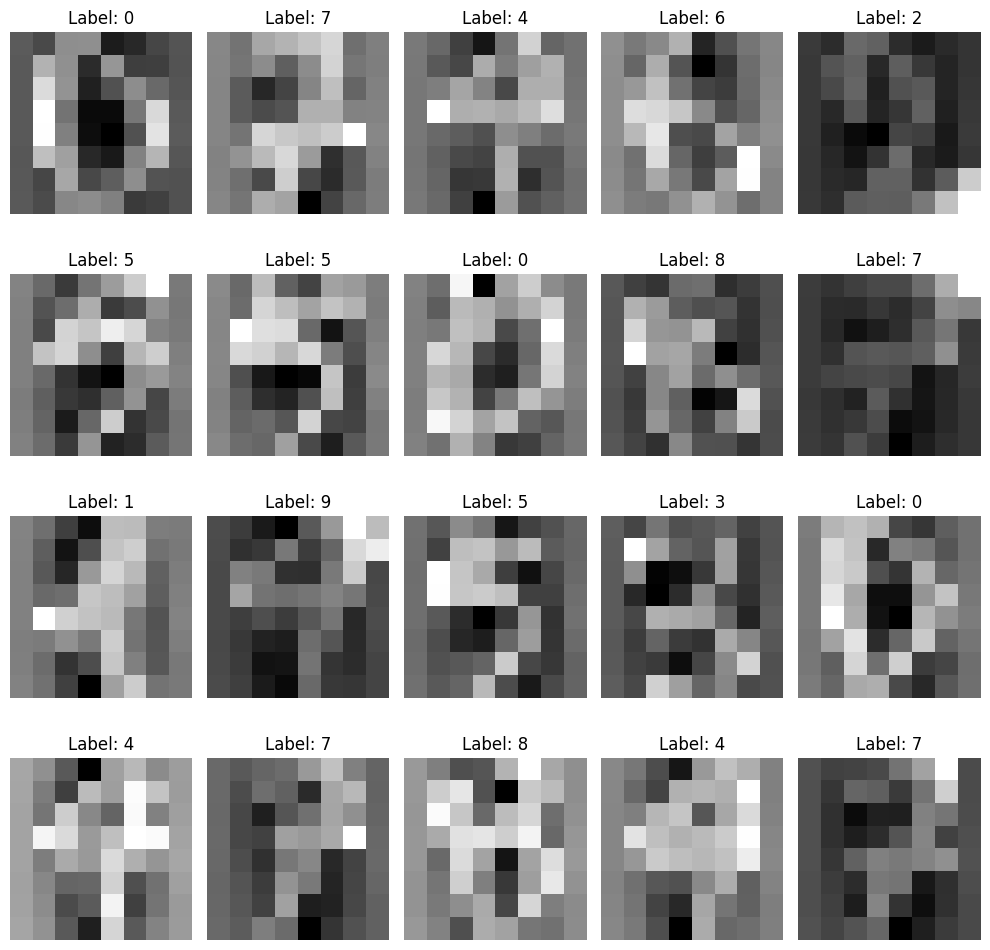

In [2]:
train_data = pd.read_csv("data/optdigits.tra")
test_data = pd.read_csv("data/optdigits.tes")

X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

normalize = True



if normalize:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

# Visualize the data
fig, axes = plt.subplots(4, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

y_test = pd.get_dummies(y_test).values.astype(np.float64)
y_train = pd.get_dummies(y_train).values.astype(np.float64)


The grayscale images can be visualized as above. We used 
`fig, axes = plt.subplots(4, 5, figsize=(10, 10))`
to locate the grayscale graphs. We then use the enumerate function and a for loop to iterate through all graphs, and to draw them out.

In [3]:
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

trained = False

Training data shape: (3822, 64)
Testing data shape: (1796, 64)


In [4]:
class MLPMultiClass(MLP):

    def __init__(self, layers, epochs=1000, lr=0.01, input_shape=1, output_shape=1):
        super().__init__(layers, epochs, lr, input_shape, output_shape)
        
    def softmax(self, logits):
        # Returns a list of probabilities, does not change the dimension.
        exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True) 

    def get_loss(self, y_pred_logit, y_true):
        y_pred = self.softmax(y_pred_logit)
        # Clip predictions to prevent division by zero
        y_pred = np.clip(y_pred, 1e-12, 1. - 1e-12)
        # Compute cross-entropy loss
        return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

    def get_loss_grad(self, y_pred_logit, y_true):
        # The loss here is the cross-entropy loss
        # It accepts matrix with the shape (x, n_classes)
        # Where x is the number of samples and n_classes is the number of classes

        y_pred_logit = y_pred_logit.reshape(-1, self.output_shape)
        # Clip predictions to prevent division by zero
        # y_pred = np.clip(y_pred, 1e-12, 1. - 1e-12)
        # Compute gradient of cross-entropy loss
        y_pred = self.softmax(y_pred_logit)
        return y_pred - y_true
    
    def predict(self, X):
        # Forward pass
        y_pred_logit = self.forward(X)       
        return np.argmax(self.softmax(y_pred_logit), axis=1)

In [13]:
layers = [
        Linear(input_size=64, output_size=128),
        ReLU(),
        Linear(input_size=128, output_size=256),
        ReLU(),
        # Linear(input_size=128, output_size=256),
        # ReLU(),
        Linear(input_size=256, output_size=10),
        Sigmoid()
    ]

epochs = 100
lr = 1e-1

mlp = MLPMultiClass(layers, epochs=epochs, lr=lr, input_shape=X_train.shape[1], output_shape=10)
mlp.train_MBGD(X_train, y_train)



Training MBGD: 100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


# 2. Evaluation and Demonstration of Results

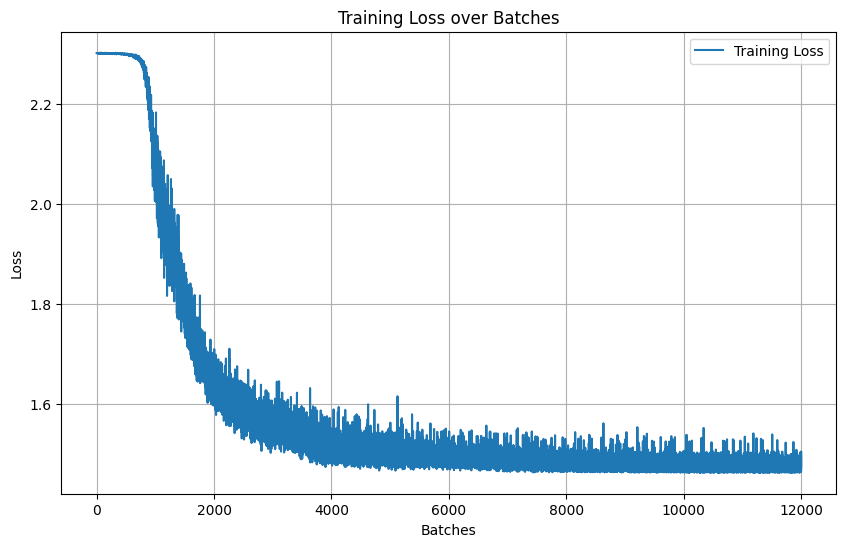

In [14]:
# %%script true
loss_history = mlp.loss
length = len(loss_history)

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(length), loss_history, label='Training Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Training Loss over Batches')
plt.legend()
plt.grid(True)
plt.show()

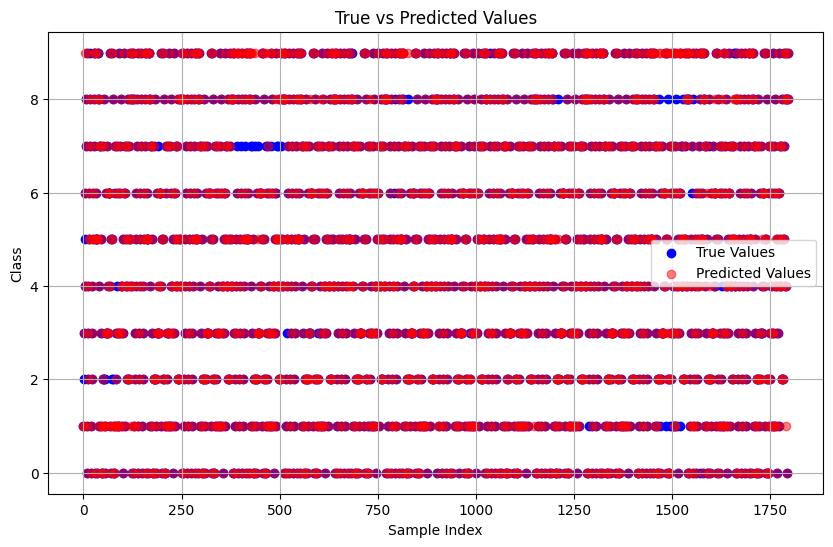

In [15]:
# %%script true
# Perform inference on the test dataset
y_pred = mlp.predict(X_test)
y_test_numerical = np.argmax(y_test, axis=1)

# Print the predicted values
# print(y_pred)
# Visualize the predicted values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_numerical)), y_test_numerical, color='blue', label='True Values')
plt.scatter(range(len(y_test_numerical)), y_pred, color='red', alpha=0.5, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.title('True vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()